<center><b>CSIE604284 • Analitika Media Sosial</b></center>
<center><b>Fakultas Ilmu Komputer, Universitas Indonesia</b></center>
<center><b>Self Paced Learning - Topic Modeling</b></center>

<b>Instruksi Pengerjaan</b>:
* Self learning ini juga termasuk tugas
* Tugas ini adalah tugas individu namun Anda diperbolehkan berdiskusi dengan teman dalam proses pengerjaan tugas. 
* Anda diberikan berkas TopicModelling.ipynb dan kumpulan data
* Tuliskan jawaban Anda pada berkas ini dan kumpulkan melalui SCeLE dengan format penamaan <b>TopicModelling_Nama_NPM.ipynb</b> sebelum <b>Senin, 21 Maret 2022 pukul 22:00.</b>

# <b>A. Topic Modeling</b><br>
    
<i>Topic modeling</i> adalah suatu teknik <i>unsupervised learning</i> untuk mengekstrak topik-topik yang ada pada suatu kumpulan dokumen teks. Satu dokumen dapat memiliki lebih dari satu topik. <i>Topic modeling</i> dapat membantu mengeksplorasi dokumen teks dengan jumlah yang besar untuk menemukan kelompok kata, kesamaan antara dokumen, menemukan topik abstrak, melakukan <i>clustering</i> dokumen, dan sebagainya. Salah satu penerapannya adalah untuk menyusun buku-buku yang memiliki topik yang mirip berdasarkan isi buku-buku tersebut.  

<img src="https://i.ibb.co/0srwgNv/blei.png" alt="blei image" style="width:75%; height:50%;">
<center>Sumber gambar: Blei, D. M. (2012). Probabilistic topic models. <i>Communications of the ACM, 55</i>(4), 77-84</center>

Terdapat beberapa pendekatan dalam menentukan topik pada suatu teks, misalnya pendekatan Term Frequency and Inverse Document Frequency (TF-IDF), Non-Negative Matrix Factorization (NMF), Latent Semantic Analysis (LSA), dan Latent Dirichlet Allocation (LDA). Pada tutorial kali ini akan dilakukan <i>topic modeling</i> menggunakan pendekatan LDA. Pendekatan LDA dalam <i>topic modeling</i> menganggap setiap dokumen sebagai kumpulan topik dalam proporsi tertentu dan setiap topik sebagai kumpulan kata kunci dalam proporsi tertentu. Topik pada LDA merupakan kumpulan kata kunci dominan yang dapat mewakilkan suatu ciri khas. 

<img src="https://i.ibb.co/QKpbhQx/lda.png" alt="lda image" style="width:75%; height:50%;">
<center>Sumber gambar: http://chdoig.github.io/pytexas2015-topic-modeling/#/3/4</center>


Pada self learning ini, Anda diminta untuk melakukan <i>topic modelling</i> menggunakan pendekatan LDA dengan dataset yang sudah disediakan. Langkah-langkah untuk melakukan <i>topic modelling</i> dengan pendekatan LDA menggunakan <i>dataset</i> tersebut adalah sebagai berikut:

## <b>1. Import library</b><br>
Import seluruh <i>library</i> yang dibutuhkan pada tutorial ini.

<b>#Code 1</b><br>
<i>Code</i> ini digunakan untuk melakukan unduhan dan import library yang diperlukan

In [ ]:
!pip install nltk
!pip install plotly
!pip install numpy
!pip install pandas
!pip install pyLDAvis
!pip install gensim
!pip install scikit-learn
!pip install tqdm

import os
import numpy as np
import nltk
import re
import pandas as pd
import plotly as py
import matplotlib.pyplot as plt
import plotly.graph_objs as go

import pyLDAvis.gensim_models
# jika masih error "Module not found" setelah instalasi pyldavis, 
# ubah import menjadi "pyLDAvis.gensim" dan semua kemunculan pyLDAvis di bawahnya

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import OrderedDict, Counter
from sklearn.decomposition import NMF
from wordcloud import WordCloud
from tqdm import tqdm

from gensim import corpora, models, similarities
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## <b>2. Membaca data</b><br>
Dataset yang digunakan adalah tweet yang diambil langsung dengan metode scraping melalui media sosial twitter dengan 3 keyword besar yang berbeda dengan rentang waktu 8 Februari 2022 hingga 8 Maret 2022. Setiap keyword dilakukan scrape secara terpisah dan kemudian masing - masing hasilnya digabungkan menjadi satu kesatuan dataset.

Keyword yang digunakan pada dataset yang digunakan adalah:
1. "perang rusia ukraina" -> Diterjemahkan sebagai "perang AND rusia AND ukraina"
2. "masker covid" -> Diterjemahkan sebagai "masker AND covid"
3. "makan keluarga" -> Diterjemahkan sebagai "makan AND keluarga"

Hasil final dari data yang digunakan saat ini berupa data bernama dataset.csv yang berisi 41721 baris data. Dataset akan dibaca dengan menggunakan <i>library</i> bernama pandas.

<b>#Code 2a</b><br>
<i>Code</i> ini digunakan untuk mengambil data dari sumber utama serta membaca dataset utama yang berisi tweet yang akan diolah

In [ ]:
# Mengambil data
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rFLB_1QpZhKyWFGxqPo5znTEkh7dUhPf' -O dataset.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xEIQwYre1SR71uRdQuez9MDmAUIysvAG' -O stopwordsID.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=19NOzXA8Voturopg_DTuiMns3s4M2IAUz' -O kamus_singkatan.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VjgivEr1pxyRCuyhVifPnaReFz0yd8Us' -O colloquial-indonesian-lexicon.csv

In [ ]:
# Membaca dataset
datafile = 'dataset.csv'
tweets = pd.read_csv(datafile)
tweets = tweets.drop_duplicates(subset='text')
tweets = tweets.assign(created_at=pd.to_datetime(tweets.created_at))
print('Terdapat ' + str(tweets.shape[0]) + ' Baris data tanpa duplikat tweet yang akan diolah')
tweets.head()

Terdapat 41015 Baris data tanpa duplikat tweet yang akan diolah


,id,text,created_at
0,1501241265613983745,Semalem nginep di rumah temen di kemayoran. Ti...,2022-03-08 16:59:44+00:00
1,1501241240502751233,Makan bareng keluarga di rumah :) https://t.co...,2022-03-08 16:59:38+00:00
2,1501239515020599298,@SetiaAdy_p @MrHannySahara @GeiszChalifah Maka...,2022-03-08 16:52:46+00:00
3,1501239168780828673,#BahagiaItuSederhana Bisa makan dengan keluarga,2022-03-08 16:51:24+00:00
4,1501238820506779648,@0uca @dsuperboy Pernah makan bareng bersama k...,2022-03-08 16:50:01+00:00


<b>#Code 2b</b><br>
<i>Code</i> ini digunakan untuk membuat grafik terkait aktivitas tweet sepanjang waktu

In [ ]:
# Melihat aktivitas tweet sepanjang waktu
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['created_at']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Aktivitas tweet sepanjang waktu',
    height=450,
    width=1200,
    xaxis=dict(
        title='Bulan dan tahun'
    ),
    yaxis=dict(
        title='Kuantitas tweet'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## <b>3. Pra-pemrosesan data</b><br>
Data yang berasal dari Twitter, atau lebih tepatnya adalah data yang berupa teks adalah data bersifat tidak terstruktur dalam artian data tersebut memiliki format penulisan bebas (tidak sesuai kaidah penulisan yang benar, misalnya kaidah penulisan ejaan baku bahasa indonesia). Oleh karena itu, perlu untuk dilakukan pra-pemrosesan data untuk melakukan normalisasi isi <i>tweet</i>. 

Dalam percobaan ini, dilakukan pra-pemrosesan berupa:

    a. Pembersihan tweet
    Adapun yang dilakukan untuik membersihkan tweet: lowercasing; menghapus url, string b' & RT, emoji, url, username, hashtag, tanda baca, angka, spasi berlebih, trimming, pembuangan tanda baca, dan huruf berulang. Fungsi cleaning(tweet) menerima input berupa satu buah tweet mentah bertipe string. 

<b>#Code 3a</b><br>
<i>Code</i> ini digunakan untuk pembersihan dari setiap tweet yang akan diolah, hal ini dimaksudkan agar mendapatkan data tweet yang lebih "bersih" dan lebih mudah untuk dilakukan pengolahan lebih lanjut

In [ ]:
def clean_data(tweet):
    # lowercase
    normal_tw = tweet.lower()
    # hapus b'
    normal_tw = re.sub(r'^b\'', '', normal_tw)
    # hapus RT
    normal_tw = re.sub(r'^rt ', '', normal_tw)
    # hapus emoji
    normal_tw = re.sub(r'\\x.{2}', '', normal_tw)
    # hapus www.* atau https?://* (URL)
    normal_tw = re.sub(r'((www\.[^\s]*)|(https?://[^\s]*))', '', normal_tw)
    # remove spasi berlebih
    normal_tw = re.sub(r'\s+', ' ', normal_tw)
    # trim depan belakang
    normal_tw = normal_tw.strip()
    # regex huruf yang berulang kaya haiiii (untuk fitur unigram)
    normal_regex = re.compile(r"(.)\1{1,}")
    # buang huruf yang berulang
    normal_tw = normal_regex.sub(r"\1\1", normal_tw)
    # hapus @username
    normal_tw = re.sub(r'@[^\s]+', '', normal_tw)
    # hapus hashtag
    normal_tw = re.sub(r'#[^\s]+', '', normal_tw)
    # hapus tanda baca
    normal_tw = re.sub(r'[^\w\s]', '', normal_tw) 
    # hapus angka
    normal_tw = re.sub(r'\d+', ' ', normal_tw) 
    return normal_tw

    b. Pembuangan stopwords dan normalisasi
    Daftar stopwords didapatkan dari penelitian Tala:
    Tala, F. Z. (2003). A Study of Stemming Effects on Information Retrieval in Bahasa Indonesia. M.S. thesis. M.Sc. Thesis. Master of Logic Project. Institute for Logic, Language and Computation. Universiteti van Amsterdam The Netherlands.
    
    Kamus singkatan didapatkan dari penelitian Hakim:
    Hakim, A. N. (2016). Pemrosesan Pertanyaan pada Sistem Tanya Jawab Bidang Kesehatan dengan Pendekatan Pembelajaran Mesin. Bachelor’s Thesis, Universitas Indonesia, Kampus UI Depok.
    
    Kamus alay didapatkan dari penelitian Salsabila:
    N. Aliyah Salsabila, Y. Ardhito Winatmoko, A. Akbar Septiandri and A. Jamal, "Colloquial Indonesian Lexicon," 2018 International Conference on Asian Language Processing (IALP), Bandung, Indonesia, 2018, pp. 226-229, doi: 10.1109/IALP.2018.8629151.

    Fungsi remove_stopwords_and_normalize(tweet) menerima masukan berupa tweet yang telah dibersihkan yang bertipe string.
    
<b># Code 3b</b><br>
<i>Code</i> ini digunakan untuk penghapusan stopwords dan normalisasi untuk setiap tweet yang akan diolah

In [ ]:
def remove_stopwords_and_normalize(tweet):
    token = nltk.word_tokenize(tweet)
    token_new = []
    for k in token:
        if k in df_kamus_singkatan['singkatan'].values:
            k = df_kamus_singkatan.loc[df_kamus_singkatan['singkatan']
                                       == k, 'asli'].values[0]
        if k in df_kamus_alay['slang'].values:
            k = df_kamus_alay.loc[df_kamus_alay['slang']
                                  == k, 'formal'].values[0]
        if k not in stopwords[0].values:
            token_new.append(k)

    str_clean = ' '.join(token_new)
    return str_clean

    c. Pra-pemrosesan tweet secara keseluruhan
    Pada tahap ini, akan dilakukan pemanggilan fungsi clean_data dan remove_stopwords_and_normalize yang sudah didefinisikan sebelumnya. Setelah itu akan ditampilkan sampel tiga tweet pertama hasil pra-pemrosesan.
    
<b>#Code 3c</b><br>
<i>Code</i> ini digunakan untuk memanggil fungsi - fungsi pra pemrosean data yang sebelumnya sudah didefinisikan

In [ ]:
def pra_pemrosesan(list_tweet):
    tweet_clean = []
    for tw in tqdm(list_tweet):
        normal_tweet = clean_data(tw)
        normal_tweet = remove_stopwords_and_normalize(normal_tweet)
        tweet_clean.append(normal_tweet)
    return tweet_clean

In [ ]:
raw_tweet = tweets['text']

stopwords = pd.read_csv("stopwordsID.csv", header=None)
df_kamus_singkatan = pd.read_csv('kamus_singkatan.csv')
df_kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')

# Melakukan pra pemrosesan tweet.
# CATATAN: proses ini akan memakan waktu sekitar 15-20 menit karena banyaknya data yang perlu diproses
print("Sedang memproses tweet... Mohon menunggu")
clean_tweet = pra_pemrosesan(raw_tweet)

# Menampilkan 10 tweet pertama yang telah dibersihkan
clean_tweet[:10]

Sedang memproses tweet... Mohon menunggu


100%|██████████| 41015/41015 [08:04<00:00, 84.62it/s] 


['semalam menginap rumah teman kemayoran main kesana menginap bekasi kemayoran jarak rumahku kantorku kayak keluarga berasa staycation disana seharian mainmakan bicara males²an',
 'makan bareng keluarga rumah',
 'kirim alamat kirimkan gulai otak beli kuota cebanan menonton videonya full kali makan otak kiriman mikir sih keluarga kaget mikir aneh lihatnya',
 'makan keluarga',
 'makan bareng keluarga',
 'pengin siyg enggak tau keluarga masalahyg mainmakan disuapinbaju sekolah pakeinaku enggak tau keluargasedih yaaku dewasa keadaanpadahal remaja jompo',
 'lately hariku lumayan campur aduk minggu sembelit gegara telat makan gusi bengkak sibuk ujian kabar baiknya rezeki allah disangka datengnya bikin senang banget bersyukur keluarga supportif',
 'enak kali keluarga nuntun tuh hidup damai kumpul makan enak tuh tuh',
 'liburan bareng pacar taman bunga dan sebagainya pokoknya romantis nder cocok ditonton keluarga makan malam serius',
 'baca au nyanyi tidak jelas main temenkeluarga makan']

Jika Anda menemukan bahwa hasil pra pemrosesan belum sempurna hingga menjadi sekumpulan tweet yang mengikuti ejaan bahasa indonesia baku, hal tersebut bukanlah masalah, sebab hingga saat ini memang belum ada cara yang sempurna untuk melakukan pembersihan dan pengolahan awal pada teks bahasa indonesia

## <b>4. Membuat korpus dari seluruh data <i>tweet</i></b><br>
Seluruh teks dalam dokumen <i>tweet</i> digabungkan menjadi korpus.


<b>#Code 4</b><br>
<i>Code</i> ini digunakan untuk membuat korpus yang dibentuk dari semua data tweet yang sudah dilakukan pra pemrosesan

In [ ]:
def create_tweet_corpus(list_tweet):
    corpus = []
    for tweet in list_tweet:
        if not pd.isnull(tweet):
            words = nltk.word_tokenize(tweet)
            for word in words:
                corpus.append([word])
    return corpus

tweet_corpus = create_tweet_corpus(clean_tweet)
tweet_corpus[:10]

[['semalam'],
 ['menginap'],
 ['rumah'],
 ['teman'],
 ['kemayoran'],
 ['main'],
 ['kesana'],
 ['menginap'],
 ['bekasi'],
 ['kemayoran']]

## <b> 5. Membuat <i>term dictionary</i></b><br>
Membuat <i>term dictionary</i> dari korpus yang telah dibuat. Setiap <i>term</i> unik diberikan suatu indeks.
    
<b>#Code 5</b><br>
<i>Code</i> ini digunakan untuk membuat dictionary dari korpus, dimana setiap kata unik dipetakan dengan indeks. Pembuatannya sendiri menggunakan library gensim.

In [ ]:
dictionary = corpora.Dictionary(tweet_corpus)

# Mencoba melihat 5 indeks pertama isi dari term dictionary
for index in range(10):
    print(dictionary.get(index))

semalam
menginap
rumah
teman
kemayoran
main
kesana
bekasi
jarak
rumahku


Bisa dilihat pada output dari kode diatas merupakan hasil pemetaan dari kata - kata yang muncul pada #Code 4 dengan indeks yang dimulai dari 0 hingga N, dimana N adalah banyaknya kata / term. Meskipun begitu, term dictionary dengan library gensim sudah mengolah kata yang menjadi duplikat, sehingga kata yang duplikat tetap berada di indeks yang sama dan tidak dimasukkan dalam indeks yang berbeda.

Contoh:  
Kalimat <b>asyik libur libur libur</b> jika dipetakan menjadi {0: "asyik", 1: "libur"} dan bukan menjadi {0: "asyik", 1: "libur", 2: "libur", 3: "libur"}

## <b> 6. Membuat <i>term document frequency</i></b><br>
Membuat <i>term document frequency</i> dari korpus menggunakan <i>dictionary</i> yang sudah didefinisikan sebelumnya. 

<b>#Code 6</b><br>
<i>Code</i> ini digunakan untuk membuat term document frequency. Berbeda dengan term frequency, pemetaan yang dilakukan adalah pemetaan indeks dengan frekuensi suatu kata pada dokumen.  
  
Contoh:  
Kalimat <b>asyik libur libur libur</b> terdiri dari "asyik" dengan frekuensi 1 kata, dan "libur" dengan frekuensi 3 kata. Dengan demikian term document frequency untuk kalimat tersebut adalah [(0,1),(1,3)] dimana setiap elemen pada array terbut adalah berupa tuple (indeks, frekuensi suatu kata X pada data).

In [ ]:
# Term Document Frequency: converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus = [dictionary.doc2bow(text) for text in tweet_corpus]

# Menampilkan 10 data pertama
print(corpus[:10])

[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)], [(5, 1)], [(6, 1)], [(1, 1)], [(7, 1)], [(4, 1)]]


## <b>7. Pembentukan model & <i>training</i> data menggunakan LDA</b><br>
Melakukan <i>training</i> menggunakan <i>corpus term document frequency</i>. Total topik yang dipilih sebanyak 5. Anda bisa bereksperimen dengan mengganti jumlah total topik dalam melakukan <i>training</i> pada model. Kemudian ditampilkan 10 kata yang paling penting pada setiap topik yang terbentuk pada model.

<b>#Code 7</b><br>
<i>Code</i> ini digunakan untuk membangun model LDA serta melakukan training data menggunakan model LDA yang sudah dibangun.

In [ ]:
tfidf = models.TfidfModel(corpus)  # Tahap 1 -- menginisialisasi model
corpus_tfidf = tfidf[corpus]  # Tahap 2 -- menggunakan model untuk mendapatkan corpus vectors

total_topics = 5 # Jumlah topik = 5
lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus]

# Menampilkan 10 kata paling penting pertama di masing-masing topik:
lda.show_topics(total_topics, 10)

[(0,
  '0.319*"perang" + 0.270*"ukraina" + 0.035*"vs" + 0.015*"war" + 0.014*"konflik" + 0.014*"invasi" + 0.014*"militer" + 0.010*"pasukan" + 0.008*"perbatasan" + 0.007*"informasi"'),
 (1,
  '0.081*"dunia" + 0.038*"negara" + 0.025*"ii" + 0.025*"as" + 0.022*"world" + 0.021*"eropa" + 0.010*"china" + 0.009*"langsung" + 0.009*"bikin" + 0.008*"news"'),
 (2,
  '0.334*"rusia" + 0.048*"rusiaukraina" + 0.034*"putin" + 0.020*"presiden" + 0.017*"amerika" + 0.016*"sih" + 0.013*"pecah" + 0.011*"minyak" + 0.010*"ukrainarusia" + 0.010*"semoga"'),
 (3,
  '0.019*"harga" + 0.014*"timur" + 0.013*"orang" + 0.013*"serangan" + 0.012*"latihan" + 0.011*"serang" + 0.011*"dampak" + 0.008*"barat" + 0.008*"covid" + 0.007*"melawan"'),
 (4,
  '0.052*"nato" + 0.040*"indonesia" + 0.017*"amp" + 0.014*"vladimir" + 0.013*"wilayah" + 0.013*"menyerang" + 0.009*"senjata" + 0.008*"isu" + 0.008*"ketegangan" + 0.007*"takut"')]

Dari setiap topik yang terbentuk, Anda bisa melihat kata-kata apa saja yang banyak muncul dari topik tersebut. Kemudian Anda bisa menggeneralisir topik yang dibicarakan pada klaster tersebut.

## <b>8. Visualisasi</b><br>
Dalam visualisasi ini, Anda bisa melihat persebaran kata pada setiap topik yang sudah dibentuk

<b>#Code 8a</b><br>
<i>Code</i> ini digunakan untuk menampilkan visualisasi dari model LDA dengan beberapa topic

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(panel)

<b>#Code 8b</b><br>
<i>Code</i> ini digunakan untuk membuat wordcloud. Word cloud secara umum berisi kata - kata yang muncul dalam data, yang dipetakan berdasarkan frekuensi. Semakin besar ukuran huruf suatu kata pada wordcloud, maka kata tersebut semakin sering muncul pada kumpulan data. Berikut ini adalah wordcloud yang dihasilkan dari semua tweet yang sudah dilakukan preprocessing

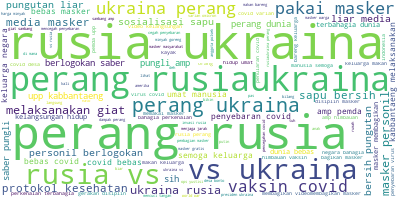

In [ ]:
long_string = ';'.join(clean_tweet)
wordcloud = WordCloud(background_color='white', max_words=5000, 
                      contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

## <b>9. Evaluasi</b><br>
Evaluasi merupakan langkah yang penting agar dapat mengetahui bagaimana kualitas dari topic modelling yang telah dibangun. Pada bagian ini akan dilakukan evaluasi model yang dibentuk menggunakan LDA dengan meghitung nilai koherensi nya (Coherence) dimana semakin tinggi nilainya maka semakin baik juga hasil topic modelling yang telah dibangun.  
Evaluasi menggunakan dua jenis skor, Perplexity dan Coherence. 

<b>#Code 9</b><br>
<i>Code</i> ini digunakan untuk melakukan evaluasi LDA dengan membentuk fungsi - fungsi yang bersifat reusable

In [ ]:
def calculate_perplexity(corpus):
    return lda.log_perplexity(corpus)

def calculate_coherence(model, word_corpus, dictionary):
    coherence_model_lda = CoherenceModel(model=model, texts=word_corpus, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [ ]:
# Menghitung nilai perplexity untuk mengetahui seberapa baik model yang dibangun, semakin kecil nilainya maka semakin baik kualitasnya
print('\nNilai Perplexity: ', calculate_perplexity(corpus))

# Menghitung nilai koherensi / coherence. Rentang nilai berada di 1 < x < 0. Nilai yang bagus biasanya berada di rentang 0,85 < x < 0,65
print('\nNilai Coherence: ', calculate_coherence(lda, tweet_corpus, dictionary))


Nilai Perplexity:  -9.780867050840747

Nilai Coherence:  0.8307328865913558


Apakah nilai tersebut sudah mencerminkan bahwa hasil topic modelling yang dirancang sudah baik ? Belum tentu, karena untuk mendapatkan hasil yang lebih baik, salah satu faktor yang dapat diperbaiki adalah menentukan jumlah topic yang akan dipetakan. Saat ini hanya menggunakan 5 topic (k=5), namun nilai topic bisa berbeda. Lantas bagaimana menentukan nilai yang lebih baik ? Akan dijelaskan dibawah ini

### <b>Mencari jumlah topic yang optimal untuk LDA</b>
Pendekatan yang digunakan disini adalah melakukan iterasi nilai K (nilai besarnya angka topic) dari rentang inklusif [x,y] kemudian untuk setiap nilai K, hitung nilai perplexity dan coherencenya.

<b>#Code 9.1a</b><br>
<i>Code</i> ini berisi fungsi yang akan digunakan untuk mencari nilai topic terbaik dan melakukan visualisasi

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Fungsi menghitung coherence (c_v) untuk berbagai nilai topic.

    Parameter:
    ----------
    dictionary : Gensim dictionary
    corpus : Korpus data asli
    texts : Korpus tweet yang berada di #Code 4
    start : nilai awal topic
    limit : batas nilai topic
    step : increment nilai topic

    Pada contoh sebelumnya, nilai topic adalah 5, namun sekarang nilai topic
    di-iterasi dari rentang [start, limit] dengan incremental sebesar 'step'

    Keluaran:
    -------
    model_list : List dari LDA topic modelling yang bersesuaian dengan nilai topic tertentu
    coherence_values : Nilai coherence dari LDA topic modelling yang bersesuaian dengan nilai topic tertentu
    """
    model_list = []
    coherence_values = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        print("Saat ini mengolah nilai topic = ", num_topics)
        # Menambahkan model - model LDA
        model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        # Menambahkan nilai - nilai coherence
        coherencemodel = calculate_coherence(model, texts, dictionary)
        coherence_values.append(coherencemodel)
        # Menambahkan nilai - nilai perplexity
        perplexityvalue = calculate_perplexity(corpus)
        perplexity_values.append(perplexityvalue)
    return model_list, coherence_values, perplexity_values

def visualize_perplexity(perplexity_values, start, limit, step):
    x = range(start, limit, step)
    plt.plot(x, perplexity_values)
    plt.xlabel("Besar nilai perplexity")
    plt.ylabel("Nilai perplexity")
    plt.legend(("perplexity_values"), loc='best')
    plt.show()

def visualize_coherence(coherence_values, start, limit, step):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Besar nilai topic")
    plt.ylabel("Nilai coherence")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

<b>#Code 9.1b</b><br>
<i>Code</i> ini berfungsi untuk menjalankan pemanggilan fungsi untuk mendapatkan daftar model, daftar nilai coherence, dan daftar nilai perplexity

Saat ini mengolah nilai topic =  1
Saat ini mengolah nilai topic =  6
Saat ini mengolah nilai topic =  11


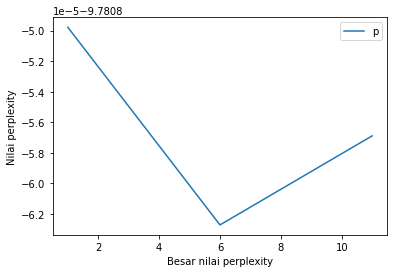

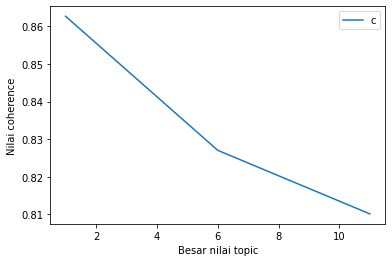

In [ ]:
# PERHATIAN: Proses ini bisa memakan waktu 10-30 menit
TOPIC_START = 1
TOPIC_LIMIT = 13
TOPIC_STEP = 5

# Pembentukan daftar nilai model dan nilai coherence nya
model_list, coherence_values, perplexity_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=tweet_corpus,
    start=TOPIC_START,
    limit=TOPIC_LIMIT,
    step=TOPIC_STEP
)

# Visualisasi nilai perplexity
visualize_perplexity(perplexity_values, TOPIC_START, TOPIC_LIMIT, TOPIC_STEP)

# Visualisasi nilai topic
visualize_coherence(coherence_values, TOPIC_START, TOPIC_LIMIT, TOPIC_STEP)

## <b>10. Topic Modelling dengan Metode Lain</b><br>
Pada self pace learning kali ini akan menggunakan K-Means Clustering dan NNMF (Non Negative Matrix Factorization)

### <b>1. Pemodelan topik menggunakan K-Means Clustering</b><br>
Salah satu algoritma <i>clustering</i> lainnya yang umum digunakan adalah K-Means. Berikut adalah kode untuk mengeksekusi algoritma K-Means menggunakan library `sklearn`. Anda dapat membandingkan hasil <i>clustering</i> yang dilakukan oleh LDA dengan K-Means.

<b>#Code 10.1a</b><br>
<i>Code</i> ini digunakan untuk membangun model K-Means Clustering dengan nilai K=5

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_tweet)

# Train algoritma K-Means
kmeans = KMeans(n_clusters=5) # jumlah klaster = 5
kmeans.fit(X)

KMeans(n_clusters=5)

<b>#Code 10.1b</b><br>
<i>Code</i> ini digunakan menampilkan beberapa hasil kata dari cluster yang sudah dibangun

In [ ]:
# Membuat dictionary untuk data cluster
clusters = {}

for tweet, cluster in zip(clean_tweet, kmeans.labels_.tolist()):
    if cluster not in clusters:
        clusters[cluster] = [tweet]
    else:
        clusters[cluster].append(tweet)

# Menampilkan sejumlah n=20 kata-kata dominan di masing-masing cluster
n_words = 20
for cluster, tweets in clusters.items():
    long_string = " ".join(tweets)
    words = nltk.word_tokenize(long_string)
    dominant_words = pd.Series(words).value_counts()[:n_words].index.to_list()

    print("Cluster " + str(cluster))
    print(" | ".join(dominant_words))
    print('='*90)

Cluster 2
makan | keluarga | bareng | orang | sih | rumah | pas | anak | malam | enak | kasih | tidak | teman | kayak | pakai | beli | suka | kerja | makanan | semoga
Cluster 0
perang | rusia | ukraina | rusiaukraina | vs | dunia | indonesia | nato | negara | putin | harga | presiden | invasi | konflik | amp | minyak | militer | orang | dampak | amerika
Cluster 4
masker | covid | penyebaran | pakai | kesehatan | disiplin | protokol | prokes | cegah | masyarakat | polsek | memakai | melaksanakan | vaksin | virus | varian | polres | gerakan | penularan | himbauan
Cluster 1
amp | sosialisasi | vaksin | personil | masker | media | covid | upp | giat | sapu | bersih | liar | pungutan | berlogokan | saber | kabbantaeng | pungli | pemda | melaksanakan | desa
Cluster 3
bebas | umat | negara | dunia | covid | masker | membagikan | video | kelangsungan | hidup | terbahagia | manusia | semoga | keluarga | perkenalan | bahagia | bahagiaㆍ | bahagiaampamp | ㅣperkenalan | ㅡperkenalan


### <b>2. Pemodelan topik menggunakan NNMF</b><br>

NNMF atau yang biasa disebut dengan Non-Negative Matrix Factorization sejatinya adalah metode statistik yang digunakan untuk menurunkan dimensi dari input yang berupa korpus. NNMF menggunakan metode analisis faktor untuk memberikan pemetaan kata - kata yang memiliki koherensi rendah dengan kata yang berbobot rendah. Cara kerja NNMF adalah dengan melakukan <i>decompose</i> vektor berdimensi tinggi men jadi vektor berdimensi rendah. Dengan menggunakan sebuah matriks (A), NNMF akan menghasilkan dua buah matriks (B dan C) dimana matriks X berisi topic yang ditemukan, dan matriks Y berisi bobot dari topik - topik tersebut.

Asumsikan ada 400  (Baris data), 5000 kata (Total) dan 50 topik, maka akan menghasilkan matriks berikut:
- A = 400 x 5000
- B = 5000 x 50
- C = 50 x 400

<b>#Code 10.2a</b><br>
<i>Code</i> ini digunakan untuk melakukan transformasi input data

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_tweet)
words = np.array(vectorizer.get_feature_names())

<b>#Code 10.2b</b><br>
<i>Code</i> ini digunakan menampilkan beberapa topic yang sudah dibangun

In [ ]:
nmf = NMF(n_components=5, solver="mu")
B = nmf.fit_transform(X)
C = nmf.components_

for i, topic in enumerate(C):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

print("")
print("Matriks B ada sebanyak " + str(len(B)) + " baris dan " + str(len(B[0])) + " kolom")
print("Matriks C ada sebanyak " + str(len(C)) + " baris dan " + str(len(C[0])) + " kolom")

Topic 1: semoga,hidup,video,manusia,bahagia,umat,perkenalan,terbahagia,kelangsungan,bebas
Topic 2: kabbantaeng,bersih,sosialisasi,saber,liar,pungutan,sapu,berlogokan,upp,amp
Topic 3: presiden,putin,nato,rusiaukraina,dunia,indonesia,vs,ukraina,perang,rusia
Topic 4: polsek,protokol,pakai,gerakan,kesehatan,penyebaran,cegah,disiplin,covid,masker
Topic 5: pas,teman,rumah,sih,enak,orang,malam,bareng,keluarga,makan

Matriks B ada sebanyak 41015 baris dan 5 kolom
Matriks C ada sebanyak 5 baris dan 39114 kolom


# <b><font color='red'>B. Tugas Self Paced Learning - Topic Modelling</font></b>

1. <b>[10 Poin]</b> Terlihat pada hasil keluaran kode pada cell #Code2a tanggal 24 Februari 2022 dan 4 Maret 2022 terjadi lonjakan aktivitas yang cukup tajam. Menurut Anda berdasarkan ketiga keyword utama yang berperan membangun dataset ini (Refer ke Section 2), keyword manakah yang menyebabkan adanya lonjakan aktivitas pada tanggal tersebut (Keyword 1/2/3) ? dan berikan alasannya.

2. <b>[10 Poin]</b> Menurut Anda, apa tujuan utama dari <i>pembentukan term document dan term document frequency</i> ? Apakah ada keuntungan dan kerugian yang mungkin diakibatkan dari proses ini apabila teknik ini tidak hanya diterapkan pada topic modelling, tapi pada aktivitas lain yang membutuhkan manipulasi data tekstual ?

3. <b>[10 Poin]</b> Berdasarkan hasil dari <b>#Code 7</b> apa maksud dari angka desimal yang muncul disamping setiap kata pada hasil keluaran kode? Berikan penjelasan Anda

4. <b>[30 Poin]</b> Cobalah untuk menjalankan tahap <b>4. Membuat korpus dari seluruh data tweet</b> hingga akhir tetapi menggunakan data tweet indeks inklusif [0,10000] , [20000,30000], dan [30000,40000] dalam percobaan terpisah, dengan begitu akan ada 3x percobaan). Apakah masing - masing penggolongan topic yang dihasilkan lebih baik (berdasarkan pengetahuan manusia) daripada apa yang dihasilkan di <b>#Code 8a</b> ? Jelaskan jawaban Anda

Catatan nomor 4, perbandingan yang dimaksud adalah
- Data indeks [10,20000] vs hasil dari <b>#Code 8a</b>
- Data indeks [20000,30000] vs hasil dari <b>#Code 8a</b>
- Data indeks [30000,akhir] vs hasil dari<b>#Code 8a</b>

5. <b>[40 Poin]</b> Anda diberikan dataset baru dengan keyword tertentu yang diambil dari tanggal 1 Januari 2021 hingga 31 Desember 2021 dengan maksimal 11000 tweets. Silakan lakukan semua tahap yang sudah diajarkan pada self paced learning ini dari mulai tahap preprocessing hingga pembentukan visualisasi dari topic modelling (awal hingga akhir). Jelaskan setiap tahap yang dilakukan dan jelaskan juga apa hasil serta kesimpulan atau hal menarik apa yang Anda dapatkan!

Ketentuan dataset:
Dataset sudah disediakan di cell bawah, cukup gunakan kolom `id`, `text` dan `created_at` saja
- Laki - laki dengan angka terakhir NPM GANJIL: keyword `menguasai dunia`
- Laki - laki dengan angka terakhir NPM GENAP: keyword `butuh liburan`
- Perempuan dengan angka terakhir NPM GANJIL: keyword `makan seblak`
- Perempuan dengan angka terakhir NPM GENAP: keyword `nonton kpop`

Jawaban nomor 5 harus mengandung:
- Preprosessing
- Pembuatan korpus
- Membuat term dictionary & term document frequency
- Pembentukan model dengan LDA
- Visualisasi
- Evaluasi

Selamat Mengerjakan!  
Jangan lupa berdoa, makan dan mencuci tangan!

# Jawaban

## 1

Agar dapat digambarkan dengan mudah, dapat dibuat wordcloud mengenai kata yang paling banyak muncul di periode tersebut. Berikut merupakan kodenya:

In [ ]:
# Mengambil data
# Membaca dataset
datafile = 'dataset.csv'
tweets = pd.read_csv(datafile)
tweets = tweets.drop_duplicates(subset='text')
tweets = tweets.assign(created_at=pd.to_datetime(tweets.created_at))


In [ ]:
# Filtering tweet berdasarkan tanggal tersebut
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%y-%m-%d %H:%M:%S')
tweets_date_filter = tweets[(tweets['created_at']> '2022-2-24') & (tweets['created_at']< '2022-3-4')]


In [ ]:
raw_tweet = tweets_date_filter['text']

stopwords = pd.read_csv("stopwordsID.csv", header=None)
df_kamus_singkatan = pd.read_csv('kamus_singkatan.csv')
df_kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')

# Melakukan pra pemrosesan tweet.
# CATATAN: proses ini akan memakan waktu sekitar 15-20 menit karena banyaknya data yang perlu diproses
print("Sedang memproses tweet... Mohon menunggu")
clean_tweet_date_filter = pra_pemrosesan(raw_tweet)

# Menampilkan 10 tweet pertama yang telah dibersihkan
clean_tweet_date_filter[:10]

Sedang memproses tweet... Mohon menunggu


100%|██████████| 21915/21915 [03:50<00:00, 95.14it/s] 


['bandar lampung makan malam keluarga kinar resto',
 'maag kambuh stres cia makan keluarga hamdalahh orang bilang stres and overthinking its my genes ngrasa santuy eh maag kambuh',
 'kangen sosok mamah keluarga guakalo acara saudara bapa mamah nawarinmau makan apapun itugua kangen mamah sih pilih cowok suka kayak berdiri kaki',
 'ultah kfc makan bareng keluarga istimewa momen jarang makan disana mahal',
 'allhamdulillah keluarga rumah makan habis jilatin tahi',
 'makan mie fess bosan keuangan keluarga anjlok seanjlok wkwkw',
 'capai pengin dikasih duit allah langsung tidak usah kerja istirahat bengek kuliah daya keluarga mesti kasih makan',
 'debut idol vlog pribadiku kayak changbin deh makan coto makassar keluarga bontang wisata bakso lino masakmasak',
 'lapar dungu makan lupa keluarga',
 'bismillah rezekinnya menang giveaway akun kakakaku pilih lightstick bts saldo kak inez alasannya memilih lightstickjujur orang hidup keluarga berkecukupanjangan beli lightstick btsbuat makan sehari²

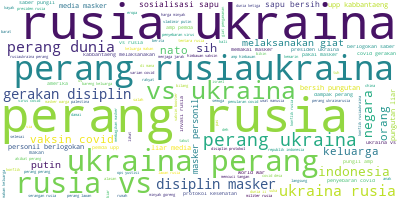

In [ ]:
long_string = ';'.join(clean_tweet_date_filter)
wordcloud = WordCloud(background_color='white', max_words=5000, 
                      contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Setelah dilihat dari wordcloud, kata yang mendominasi adalah perang rusia ukraina. Dengan begitu, topik yang membuat kelonjakan tweet pada periode tersebut kemungkinan besar adalah topik seputar perang rusia ukraina.

## 2

Aplikasi dari term document dan term document frequency salah satunya adalah untuk meningkatkan search result seperti Latent semantic analysis (LSA) yang dapat membedakan kata-kata polisemi dan mencari sinonim dari query. Namun, ia memiliki kekurangan dimana pencarian pada high-dimensional continous space lebih lambat daripada pencarian di struktur data standar dari search engine. 

Aplikasi lainnya adalah untuk menemukan topik dari suatu corpus seperti pada tugas kali ini. Beberapa penelitian menyebutkan LSA dan data clustering dapat digunakan, probabilistic LSA dengan generalization Latent Dirichlet allocation, dan non-negative matrix factorization dapat diaplikasikan dengan baik menggunakan task term document dan term document frequency. Dengan demikian, sejauh yang saya pelajari, menurut saya fungsi utama dari pembentukan tersebut adalah untuk membobotkan kemunculan term pada document sehingga dapat dilakukan analisis lanjutan untuk proses information retrieval.

Selanjutnya, kelebihan term frequency diantaranya adalah mudah dikomputasi, dapat digunakan untuk mengekstrak dari term yang paling deskriptif pada dokumen, dan untuk menghitung similaritas dari 2 dokumen dapat juga dilakukan dengan pembentukan ini. Kemudian, kekurangan dari pembentukan ini adalah berbasis bag of words model, sehingga kurang dapat menemukan posisi dari suatu teks, semantik, dan kesamaan kemunculan pada dokumen berbeda. 

Referensi:

https://en.wikipedia.org/wiki/Document-term_matrix

https://www.quora.com/What-are-the-advantages-and-disadvantages-of-TF-IDF



## 3

Berdasarkan dokumentasi disebutkan bahwa show_topics() mengembalikan 
```
a list of topics, each represented either as a string (when formatted == True) or word-probability pairs
```

Dengan begitu, angka tersebut merupakan probabilitas untuk kata-kata yang paling relevan dari topik yang dihasilkan.

## 4

In [ ]:
tweet_corpus1 = create_tweet_corpus(clean_tweet[:10001])
tweet_corpus2 = create_tweet_corpus(clean_tweet[20000:30001]) 
tweet_corpus3 = create_tweet_corpus(clean_tweet[30000:40001])

In [ ]:
dictionary = corpora.Dictionary(tweet_corpus)

# Mencoba melihat 5 indeks pertama isi dari term dictionary
for index in range(10):
    print(dictionary.get(index))

semalam
menginap
rumah
teman
kemayoran
main
kesana
bekasi
jarak
rumahku


In [ ]:
dictionary1 = corpora.Dictionary(tweet_corpus1)
dictionary2 = corpora.Dictionary(tweet_corpus2)
dictionary3 = corpora.Dictionary(tweet_corpus3)

In [ ]:
corpus1 = [dictionary1.doc2bow(text) for text in tweet_corpus1]
corpus2 = [dictionary2.doc2bow(text) for text in tweet_corpus2]
corpus3 = [dictionary3.doc2bow(text) for text in tweet_corpus3]

In [ ]:
total_topics = 5 # Jumlah topik = 5

tfidf1 = models.TfidfModel(corpus1)  # Tahap 1 -- menginisialisasi model
corpus_tfidf1 = tfidf1[corpus1]  # Tahap 2 -- menggunakan model untuk mendapatkan corpus vectors
lda1 = models.ldamodel.LdaModel(corpus1, id2word=dictionary1, num_topics=total_topics)
corpus_lda1 = lda1[corpus1]

tfidf2 = models.TfidfModel(corpus2)  # Tahap 1 -- menginisialisasi model
corpus_tfidf2 = tfidf2[corpus2]  # Tahap 2 -- menggunakan model untuk mendapatkan corpus vectors
lda2 = models.ldamodel.LdaModel(corpus2, id2word=dictionary2, num_topics=total_topics)
corpus_lda2 = lda2[corpus2]

tfidf3 = models.TfidfModel(corpus3)  # Tahap 1 -- menginisialisasi model
corpus_tfidf3 = tfidf3[corpus3]  # Tahap 2 -- menggunakan model untuk mendapatkan corpus vectors
lda3 = models.ldamodel.LdaModel(corpus3, id2word=dictionary3, num_topics=total_topics)
corpus_lda3 = lda3[corpus3]

In [ ]:
panel1 = pyLDAvis.gensim_models.prepare(lda1, corpus1, dictionary1, mds='tsne')
pyLDAvis.display(panel1)

In [69]:
panel2 = pyLDAvis.gensim_models.prepare(lda2, corpus2, dictionary2, mds='tsne')
pyLDAvis.display(panel2)


In [ ]:
panel3 = pyLDAvis.gensim_models.prepare(lda3, corpus3, dictionary3, mds='tsne')
pyLDAvis.display(panel3)

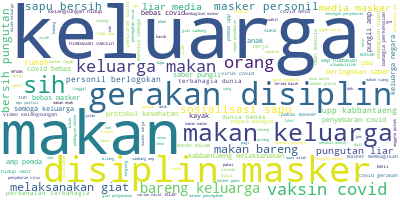

In [ ]:
long_string1 = ';'.join(clean_tweet[:10001])
wordcloud1 = WordCloud(background_color='white', max_words=5000, 
                      contour_width=3, contour_color='steelblue')
wordcloud1.generate(long_string1)
wordcloud1.to_image()

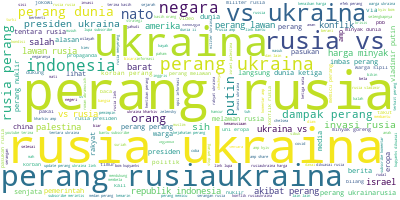

In [ ]:
long_string2 = ';'.join(clean_tweet[20000:30001])
wordcloud2 = WordCloud(background_color='white', max_words=5000, 
                      contour_width=3, contour_color='steelblue')
wordcloud2.generate(long_string2)
wordcloud2.to_image()

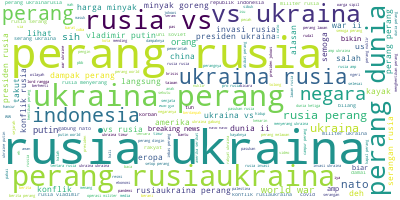

In [ ]:
long_string3 = ';'.join(clean_tweet[30000:40001])
wordcloud3 = WordCloud(background_color='white', max_words=5000, 
                      contour_width=3, contour_color='steelblue')
wordcloud3.generate(long_string3)
wordcloud3.to_image()

Berdasarkan visualisasi pada langkah #8, terlihat bahwa kata yang paling penting seputar perang rusia ukraina. Pada topik 1 dapat dilihat memiliki berbagai keyword yang sebenarnya kurang relevan dengan topik utama yang tidak diketahui sebenarnya apa, topik 2 cukup menggambarkan perang, topik 3 tentang dunia, topik 4 cukup menggambarkan rusia ukraina, dan topik 5 juga cukup menggambarkan perang. 

Pada tweet [0,10000], terlihat kata yang paling penting kira-kira adalah covid, sedangkan pada tweet [20000,30000] dan [30000,40000] terlihat kata kata yang paling penting kira-kira adalah seputar perang rusia ukraina. Selanjutnya, pada setiap topik dari ketiga kumpulan tweet mirip dengan pada step #8 dimana terdapat topik dengan kata-kata yang saling berhubungan dan ada juga yang kurang berhubungan menurut saya. Menurut saya sebagai manusia, penggolongan keduanya tidak terlalu berbeda. Terdapat topik yang kata-kata nya relevan dan ada juga yang tidak. Berdasarkan visualisasi, pada langkah #8, tweet [20000,30000], dan [30000,40000] semua topiknya kurang lebih adalah sama mengenai perang rusia ukraina, sedangkan penggolongan pada tweet [0,10000] lebih bervariasi dengan unsur utama covid. Namun, pada berbagai topik tersebut tetap saja ada topik yang kata-katanya relevan, dan ada juga yang kurang relevan. 


## 5

In [ ]:
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1aGY6y9vABCKD08MkA6Rwv2FkALHf5VbY' -O butuh_liburan.csv

In [ ]:
# Dataset keyword "butuh liburan", silakan di-uncomment semua baris di bawah ini

datafile_b = 'butuh_liburan.csv'
tweets_b = pd.read_csv(datafile_b)

tweets = tweets_b.filter(["id", "text", "created_at"]) 

In [ ]:
# Melihat aktivitas tweet sepanjang waktu
tweets = tweets.assign(created_at=pd.to_datetime(tweets.created_at))
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['created_at']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Aktivitas tweet sepanjang waktu',
    height=450,
    width=1200,
    xaxis=dict(
        title='Bulan dan tahun'
    ),
    yaxis=dict(
        title='Kuantitas tweet'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
raw_tweet = tweets['text']

stopwords = pd.read_csv("stopwordsID.csv", header=None)
df_kamus_singkatan = pd.read_csv('kamus_singkatan.csv')
df_kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')

# Melakukan pra pemrosesan tweet.
# CATATAN: proses ini akan memakan waktu sekitar 15-20 menit karena banyaknya data yang perlu diproses
print("Sedang memproses tweet... Mohon menunggu")
clean_tweet = pra_pemrosesan(raw_tweet)

# Menampilkan 10 tweet pertama yang telah dibersihkan
clean_tweet[:10]

Sedang memproses tweet... Mohon menunggu


100%|██████████| 10324/10324 [01:22<00:00, 125.61it/s]


['tidak bisa menyalahkan sih menyalahkan telat nyadarnya butuh liburan menyadari liburan ngumpulin duit wkwk',
 'askrl orangtua membolehkan liburan butuh pergi literally sih teman disana orangtua kenal teman flight tidak pakai cont',
 'teman kebanyakan acara liburan manusia bergantung orang faktanya manusia butuh bantuan manusia bertahan hidup',
 'badan pengin liburan dompet butuh lembaran',
 'liburan orang butuh mobil sewa cahyatransport lengkap paket wisata allin mobilnya berat badan bd',
 'keluh butuh liburan hiburan liburan main iya main main berkedok melepas stres disitu kepikiran pekerjaan kepikiran capai butuh hiburan main',
 'butuh liburan hiburan resign',
 'terkadang butuh liburan',
 'situasi depresi liburan pergi kota rumah stres relief pergi butuh',
 'amin butuh kerja liburan pliss']

Membuat corpus

In [ ]:
tweet_corpus = create_tweet_corpus(clean_tweet)
tweet_corpus[:10]

[['tidak'],
 ['bisa'],
 ['menyalahkan'],
 ['sih'],
 ['menyalahkan'],
 ['telat'],
 ['nyadarnya'],
 ['butuh'],
 ['liburan'],
 ['menyadari']]

In [ ]:
dictionary = corpora.Dictionary(tweet_corpus)

# Mencoba melihat 5 indeks pertama isi dari term dictionary
for index in range(10):
    print(dictionary.get(index))

tidak
bisa
menyalahkan
sih
telat
nyadarnya
butuh
liburan
menyadari
ngumpulin


In [ ]:
# Term Document Frequency: converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus = [dictionary.doc2bow(text) for text in tweet_corpus]

# Menampilkan 10 data pertama
print(corpus[:10])

[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(2, 1)], [(4, 1)], [(5, 1)], [(6, 1)], [(7, 1)], [(8, 1)]]


In [ ]:
tfidf = models.TfidfModel(corpus)  # Tahap 1 -- menginisialisasi model
corpus_tfidf = tfidf[corpus]  # Tahap 2 -- menggunakan model untuk mendapatkan corpus vectors

total_topics = 5 # Jumlah topik = 5
lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus]

# Menampilkan 10 kata paling penting pertama di masing-masing topik:
lda.show_topics(total_topics, 10)

[(0,
  '0.036*"travel" + 0.031*"kayaknya" + 0.025*"orang" + 0.023*"hiburan" + 0.021*"refreshing" + 0.020*"capai" + 0.019*"sebal" + 0.019*"moodbooster" + 0.017*"staycation" + 0.013*"wajib"'),
 (1,
  '0.547*"liburan" + 0.031*"gemurai" + 0.017*"paket" + 0.015*"deh" + 0.015*"pusing" + 0.013*"taksi" + 0.013*"detikcom" + 0.013*"tidak" + 0.013*"badan" + 0.013*"mana"'),
 (2,
  '0.023*"hubungi" + 0.019*"duit" + 0.018*"iya" + 0.017*"bosan" + 0.015*"transportasi" + 0.014*"cek" + 0.013*"indonesia" + 0.013*"menghilangkan" + 0.013*"bismillah" + 0.013*"keliling"'),
 (3,
  '0.044*"amp" + 0.035*"stres" + 0.035*"tour" + 0.019*"bandung" + 0.017*"pengin" + 0.015*"lupakan" + 0.012*"ke" + 0.012*"pesawat" + 0.012*"solusinya" + 0.011*"pekerjaan"'),
 (4,
  '0.608*"butuh" + 0.037*"sih" + 0.027*"cirebon" + 0.024*"kerja" + 0.019*"uang" + 0.013*"biar" + 0.013*"kayak" + 0.011*"mudik" + 0.011*"hemat" + 0.010*"kali"')]

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(panel)

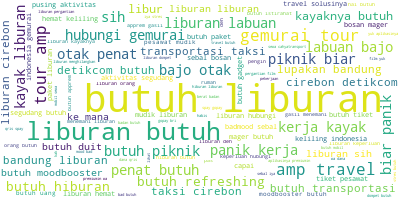

In [ ]:
long_string = ';'.join(clean_tweet)
wordcloud = WordCloud(background_color='white', max_words=5000, 
                      contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# Menghitung nilai perplexity untuk mengetahui seberapa baik model yang dibangun, semakin kecil nilainya maka semakin baik kualitasnya
print('\nNilai Perplexity: ', calculate_perplexity(corpus))

# Menghitung nilai koherensi / coherence. Rentang nilai berada di 1 < x < 0. Nilai yang bagus biasanya berada di rentang 0,85 < x < 0,65
print('\nNilai Coherence: ', calculate_coherence(lda, tweet_corpus, dictionary))


Nilai Perplexity:  -7.15031702411214

Nilai Coherence:  0.8347283251605224


Saat ini mengolah nilai topic =  1
Saat ini mengolah nilai topic =  6
Saat ini mengolah nilai topic =  11


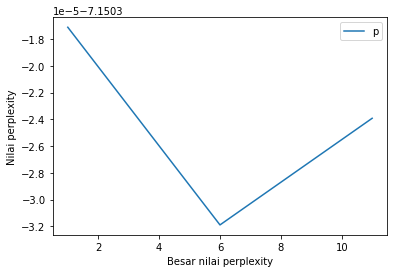

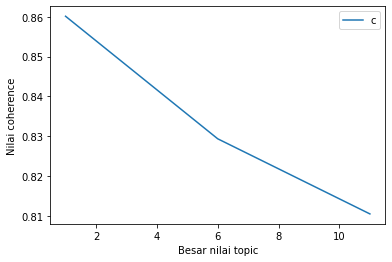

In [ ]:
TOPIC_START = 1
TOPIC_LIMIT = 13
TOPIC_STEP = 5

# Pembentukan daftar nilai model dan nilai coherence nya
model_list, coherence_values, perplexity_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=tweet_corpus,
    start=TOPIC_START,
    limit=TOPIC_LIMIT,
    step=TOPIC_STEP
)

# Visualisasi nilai perplexity
visualize_perplexity(perplexity_values, TOPIC_START, TOPIC_LIMIT, TOPIC_STEP)

# Visualisasi nilai topic
visualize_coherence(coherence_values, TOPIC_START, TOPIC_LIMIT, TOPIC_STEP)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_tweet)

# Train algoritma K-Means
kmeans = KMeans(n_clusters=5) # jumlah klaster = 5
kmeans.fit(X)

KMeans(n_clusters=5)

In [ ]:
# Membuat dictionary untuk data cluster
clusters = {}

for tweet, cluster in zip(clean_tweet, kmeans.labels_.tolist()):
    if cluster not in clusters:
        clusters[cluster] = [tweet]
    else:
        clusters[cluster].append(tweet)

# Menampilkan sejumlah n=20 kata-kata dominan di masing-masing cluster
n_words = 20
for cluster, tweets in clusters.items():
    long_string = " ".join(tweets)
    words = nltk.word_tokenize(long_string)
    dominant_words = pd.Series(words).value_counts()[:n_words].index.to_list()

    print("Cluster " + str(cluster))
    print(" | ".join(dominant_words))
    print('='*90)

Cluster 3
butuh | liburan | sih | kerja | cirebon | kayaknya | orang | yuk | stres | hiburan | refreshing | capai | duit | deh | libur | uang | iya | sebal | moodbooster | badan
Cluster 1
liburan | butuh | ㅤ | v | _ | a
Cluster 2
butuh | gemurai | amp | tour | travel | liburan | hubungi | indonesia | keliling | hemat | paket | solusinya | pusing | aktivitas | segudang | tiket | pesawat | mudik | keperluan
Cluster 4
liburan | labuan | bajo | otak | penat | butuh | piknik | biar | panik | kerja | kayak
Cluster 0
bismillah | butuh | liburan | menghilangkan | stres | staycation | wajib | cek | traveloka | epic | sale


Pemodelan menggunakan NNMF

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_tweet)
words = np.array(vectorizer.get_feature_names())

In [70]:
nmf = NMF(n_components=5, solver="mu")
B = nmf.fit_transform(X)
C = nmf.components_

for i, topic in enumerate(C):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))


Topic 1: capai,badan,stres,duit,uang,hiburan,sih,kayaknya,butuh,liburan
Topic 2: capai,kerja,biar,kayak,otak,penat,piknik,bajo,labuan,panik
Topic 3: mudik,keperluan,pusing,aktivitas,segudang,hubungi,amp,travel,tour,gemurai
Topic 4: dom,save,cimahi,kucingnya,bandung,transportasi,taksi,lupakan,detikcom,cirebon
Topic 5: stres,iya,hiburan,butuh,bosan,mager,gadget,badmood,moodbooster,sebal


Insight yang saya dapatkan adalah dapat dilihat orang yang meng-tweet terkait topik tersebut mengalami lonjakan pada sekitar akhir November hingga Desember. Saat dilihat tanggalnya lebih lanjut, hari tersebut rata-rata adalah weekend.

Selain itu, saya juga dapat mengetahui destinasi wisata yang cukup sering muncul atau populer bersamaan dengan kata liburan pada periode tersebut dan alasan butuh liburan pun dapat diketahui sehingga para agen travel dapat berpotensi mempersiapkan peningkatkan promosi untuk dapat memberikan pelayanan terbaik untuk pelanggannya demi mencapai tujuan bisnis perusahaan.